In [4]:
# Core
import pandas as pd
import numpy as np
import json, logging, warnings, re
warnings.filterwarnings("ignore")

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             balanced_accuracy_score, f1_score, roc_curve, auc)
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.over_sampling import SMOTE

# Plotting
import matplotlib.pyplot as plt

# Save/Load
import joblib, os

# Extra
import xgboost as xgb
from difflib import get_close_matches

# Optional web helpers (Wikipedia)
import requests
from bs4 import BeautifulSoup

# ==== SHAP INTEGRATION ====
try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

# Logging
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

In [9]:
def load_and_clean_data(csv_path="boxing_data.csv"):
    df = pd.read_csv(csv_path)

    # Binary target: 1 stays 1 (A wins), everything else -> 0
    df["Result"] = df["Result"].apply(lambda x: 1 if x == 1 else 0)

    numeric_cols = [
        "ReachA","ReachB","HeightA","HeightB","WeightA","WeightB",
        "AgeA","AgeB","WinsA","WinsB","KOPercA","KOPercB",
        "RecentWinPercA","RecentWinPercB","DefensePercA","DefensePercB",
        "PunchAccuracyA","PunchAccuracyB","StrengthOfScheduleA","StrengthOfScheduleB",
        "TimeSinceLastFightA","TimeSinceLastFightB","Result"
    ]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
    df = df.dropna(subset=["Result"])

    logging.info(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")
    print(df["Result"].value_counts(normalize=True).rename("proportion"))
    return df

df = load_and_clean_data("boxing_data.csv")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'boxing_data.csv'

In [13]:
def engineer_features(df):
    # Primary diffs
    df["ReachDiff"]      = df["ReachA"]  - df["ReachB"]
    df["AgeDiff"]        = df["AgeA"]    - df["AgeB"]
    df["HeightDiff"]     = df["HeightA"] - df["HeightB"]
    df["WeightDiff"]     = df["WeightA"] - df["WeightB"]
    df["KODiff"]         = df["KOPercA"] - df["KOPercB"]
    df["WinDiff"]        = df["WinsA"]   - df["WinsB"]
    df["RecentWinPercDiff"] = df["RecentWinPercA"] - df["RecentWinPercB"]
    df["DefenseDiff"]    = df["DefensePercA"] - df["DefensePercB"]
    df["PunchAccDiff"]   = df["PunchAccuracyA"] - df["PunchAccuracyB"]
    df["SoSDiff"]        = df["StrengthOfScheduleA"] - df["StrengthOfScheduleB"]
    df["TimeSinceDiff"]  = df["TimeSinceLastFightA"] - df["TimeSinceLastFightB"]

    # Interactions
    df["PowerVsSchedule"]   = df["KODiff"] * df["SoSDiff"]
    df["WinsVsSchedule"]    = df["WinDiff"] * df["SoSDiff"]
    df["RecentFormWeighted"] = df["RecentWinPercDiff"] * (1 + 0.5 * (df["SoSDiff"] / (1 + df["SoSDiff"].abs())))

    feature_cols = [
        "ReachDiff","AgeDiff","HeightDiff","WeightDiff",
        "KODiff","WinDiff","RecentWinPercDiff","DefenseDiff","PunchAccDiff",
        "SoSDiff","TimeSinceDiff",
        "PowerVsSchedule","WinsVsSchedule","RecentFormWeighted"
    ]
    return df, feature_cols

df, feature_cols = engineer_features(df)
len(feature_cols), feature_cols

(14,
 ['ReachDiff',
  'AgeDiff',
  'HeightDiff',
  'WeightDiff',
  'KODiff',
  'WinDiff',
  'RecentWinPercDiff',
  'DefenseDiff',
  'PunchAccDiff',
  'SoSDiff',
  'TimeSinceDiff',
  'PowerVsSchedule',
  'WinsVsSchedule',
  'RecentFormWeighted'])

In [14]:
X = df[feature_cols].copy()
y = df["Result"].astype(int).copy()

imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Balance training set only
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

logging.info(f"Before SMOTE: {y_train.value_counts().to_dict()}")
logging.info(f"After SMOTE: {y_train_res.value_counts().to_dict()}")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

INFO: Before SMOTE: {1: 154, 0: 89}
INFO: After SMOTE: {0: 154, 1: 154}


In [15]:
# Random Forest search
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_dist = {
    "n_estimators":  [200, 300, 500, 700, 900],
    "max_depth":     [6, 10, 14, 18, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_features":  ["sqrt", "log2", None]
}
rf_search = RandomizedSearchCV(
    rf, rf_dist, n_iter=30, scoring="roc_auc", cv=cv, n_jobs=-1, random_state=42, verbose=0
)
rf_search.fit(X_train_res, y_train_res)
rf_best = rf_search.best_estimator_
logging.info(f"RF best params: {rf_search.best_params_}")

# XGBoost search
xgb_base = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    tree_method="hist",
    n_jobs=-1
)
xgb_dist = {
    "n_estimators": [300, 500, 700, 900],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.02, 0.03, 0.05, 0.08, 0.1],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7]
}
xgb_search = RandomizedSearchCV(
    xgb_base, xgb_dist, n_iter=30, scoring="roc_auc", cv=cv, n_jobs=-1, random_state=42, verbose=0
)
xgb_search.fit(X_train_res, y_train_res)
xgb_best = xgb_search.best_estimator_
logging.info(f"XGB best params: {xgb_search.best_params_}")

INFO: RF best params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 18}
INFO: XGB best params: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.02, 'colsample_bytree': 0.6}



=== ENSEMBLE (Calibrated) ===
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        22
           1       0.86      0.95      0.90        39

    accuracy                           0.87        61
   macro avg       0.87      0.84      0.85        61
weighted avg       0.87      0.87      0.87        61

Confusion Matrix:
 [[16  6]
 [ 2 37]]
Accuracy: 0.8688524590163934
Balanced Accuracy: 0.837995337995338
ROC AUC: 0.8554778554778555
Macro F1: 0.851219512195122


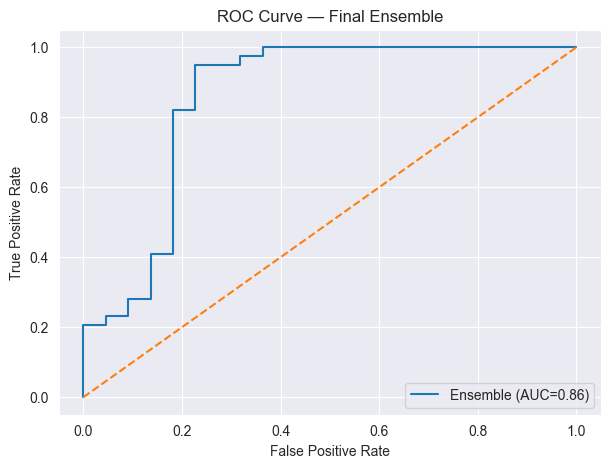

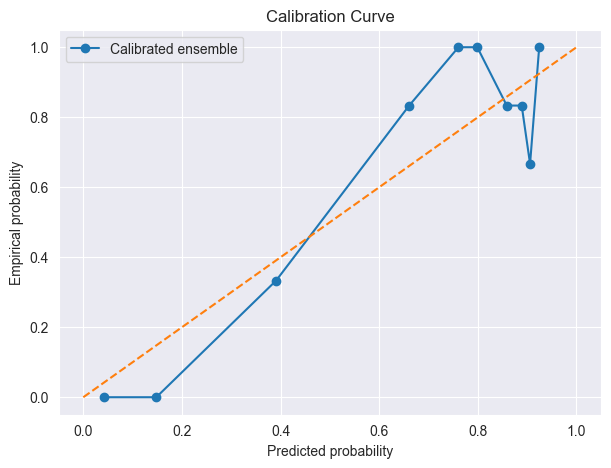

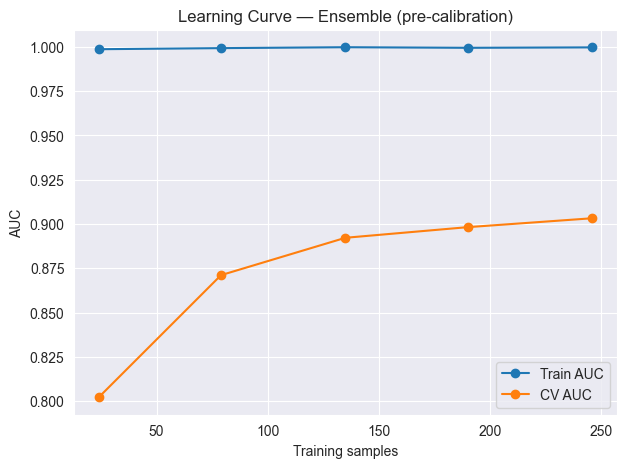

In [16]:
# Build ensemble
logreg = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
ensemble = VotingClassifier(
    estimators=[("rf", rf_best), ("xgb", xgb_best), ("lr", logreg)],
    voting="soft",
    n_jobs=-1
)

# Fit + calibrate
ensemble.fit(X_train_res, y_train_res)
final_model_calibrated = CalibratedClassifierCV(ensemble, cv=3, method="sigmoid")
final_model_calibrated.fit(X_train_res, y_train_res)

# Evaluate on hold-out
y_pred = final_model_calibrated.predict(X_test)
y_proba = final_model_calibrated.predict_proba(X_test)[:, 1]

print("\n=== ENSEMBLE (Calibrated) ===")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", (y_pred == y_test).mean())
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"Ensemble (AUC={auc(fpr, tpr):.2f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Final Ensemble"); plt.legend(); plt.show()

# Calibration (reliability) curve
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy='quantile')
plt.figure(figsize=(7,5))
plt.plot(prob_pred, prob_true, marker='o', label="Calibrated ensemble")
plt.plot([0,1],[0,1],"--")
plt.xlabel("Predicted probability"); plt.ylabel("Empirical probability")
plt.title("Calibration Curve"); plt.legend(); plt.show()

# Learning curve (on uncalibrated ensemble for speed)
train_sizes, train_scores, valid_scores = learning_curve(
    ensemble, X_train_res, y_train_res, cv=5, scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, shuffle=True, random_state=42
)
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label="Train AUC")
plt.plot(train_sizes, valid_scores.mean(axis=1), marker='o', label="CV AUC")
plt.xlabel("Training samples"); plt.ylabel("AUC")
plt.title("Learning Curve — Ensemble (pre-calibration)"); plt.legend(); plt.show()

In [17]:
joblib.dump(final_model_calibrated, "fight_predictor_ensemble.pkl")
logging.info("Saved calibrated ensemble to fight_predictor_ensemble.pkl")

INFO: Saved calibrated ensemble to fight_predictor_ensemble.pkl


In [18]:
# Build per-fighter stats dict from both A & B perspectives
fighters_stats = {}
for _, row in df.iterrows():
    fighters_stats[row["FighterA"]] = {
        "Reach": row["ReachA"], "Age": row["AgeA"], "Height": row["HeightA"],
        "Weight": row["WeightA"], "KO%": row["KOPercA"], "Wins": row["WinsA"],
        "RecentWin%": row["RecentWinPercA"], "Defense%": row["DefensePercA"],
        "PunchAcc": row["PunchAccuracyA"], "SoS": row["StrengthOfScheduleA"],
        "TimeSince": row["TimeSinceLastFightA"]
    }
    fighters_stats[row["FighterB"]] = {
        "Reach": row["ReachB"], "Age": row["AgeB"], "Height": row["HeightB"],
        "Weight": row["WeightB"], "KO%": row["KOPercB"], "Wins": row["WinsB"],
        "RecentWin%": row["RecentWinPercB"], "Defense%": row["DefensePercB"],
        "PunchAcc": row["PunchAccuracyB"], "SoS": row["StrengthOfScheduleB"],
        "TimeSince": row["TimeSinceLastFightB"]
    }

all_fighters = sorted(set(fighters_stats.keys()))

# Optional: alias map to control exact mapping (prevents Sr↔Jr)
alias_map = {
    # "Floyd Mayweather Jr": "Floyd Mayweather Jr",
    # "Floyd Mayweather": "Floyd Mayweather Jr",
}

def list_fighters_like(substring):
    return [f for f in all_fighters if substring.lower() in f.lower()]

def register_alias(alias, canonical):
    alias_map[alias] = canonical

def _resolve_name(name, choices, cutoff=0.95):
    """Strict resolver: exact match or high-confidence fuzzy, with alias override."""
    if name in alias_map:
        return alias_map[name]
    if name in choices:
        return name
    cand = get_close_matches(name, choices, n=1, cutoff=cutoff)
    if cand:
        return cand[0]
    raise ValueError(f"Fighter '{name}' not found. Try one of: {choices[:10]} ...")

len(all_fighters), all_fighters[:10]

(367,
 ['Aaron Pryor',
  'Abner Mares',
  'Acelino Freitas',
  'Adonis Stevenson',
  'Adrien Broner',
  'Alexis Arguello',
  'Alfredo Angulo',
  'Alycia Baumgardner',
  'Amanda Serrano',
  'Amir Khan'])

In [19]:
def _build_feature_row(statsA, statsB):
    feats = {
        "ReachDiff": statsA["Reach"] - statsB["Reach"],
        "AgeDiff": statsA["Age"] - statsB["Age"],
        "HeightDiff": statsA["Height"] - statsB["Height"],
        "WeightDiff": statsA["Weight"] - statsB["Weight"],
        "KODiff": statsA["KO%"] - statsB["KO%"],
        "WinDiff": statsA["Wins"] - statsB["Wins"],
        "RecentWinPercDiff": statsA["RecentWin%"] - statsB["RecentWin%"],
        "DefenseDiff": statsA["Defense%"] - statsB["Defense%"],
        "PunchAccDiff": statsA["PunchAcc"] - statsB["PunchAcc"],
        "SoSDiff": statsA["SoS"] - statsB["SoS"],
        "TimeSinceDiff": statsA["TimeSince"] - statsB["TimeSince"]
    }
    feats["PowerVsSchedule"] = feats["KODiff"] * feats["SoSDiff"]
    feats["WinsVsSchedule"]  = feats["WinDiff"] * feats["SoSDiff"]
    feats["RecentFormWeighted"] = feats["RecentWinPercDiff"] * (1 + 0.5 * (feats["SoSDiff"] / (1 + abs(feats["SoSDiff"]))))

    return pd.DataFrame([feats])[feature_cols]

In [20]:
def predict_fight(fighterA, fighterB, model=final_model_calibrated, imputer_obj=imputer, return_dict=False):
    A = _resolve_name(fighterA, all_fighters)
    B = _resolve_name(fighterB, all_fighters)

    statsA, statsB = fighters_stats[A], fighters_stats[B]
    X_pred = _build_feature_row(statsA, statsB)
    X_pred = pd.DataFrame(imputer_obj.transform(X_pred), columns=feature_cols)

    proba_A = model.predict_proba(X_pred)[0, 1]   # P(Fighter A wins)
    pred_A_wins = proba_A >= 0.5
    winner = A if pred_A_wins else B
    confidence = float(proba_A if pred_A_wins else (1 - proba_A))

    if return_dict:
        return {"fighter_A": A, "fighter_B": B, "winner": winner, "confidence": confidence}
    return f"Predicted winner: {winner} (Confidence: {confidence:.2f})"

print(predict_fight("Naoya Inoue", "Floyd Mayweather"))

Predicted winner: Naoya Inoue (Confidence: 0.67)


In [21]:
# ==== ENSEMBLE SHAP (helpers) ====
def _coef_contrib_logreg(model: LogisticRegression, row_values: np.ndarray) -> np.ndarray:
    """
    Simple linear contribution: coef * value for each feature.
    Assumes binary classification; uses the positive class coefs (model.coef_[0]).
    """
    coefs = np.asarray(model.coef_[0])
    return coefs * row_values

def _tree_shap_values(model, row_df):
    """
    SHAP TreeExplainer for tree models (XGBoost, RandomForest, etc.).
    Returns a 1D array of shap values for the provided single-row DataFrame.
    """
    explainer = shap.TreeExplainer(model)
    vals = explainer.shap_values(row_df)
    # xgboost returns (n_features,) for single row; RF may return shape (1, n_features)
    vals = np.array(vals)
    if vals.ndim == 2 and vals.shape[0] == 1:
        vals = vals[0]
    return vals

def ensemble_shap_explain(row_df, feature_cols, models: dict, weights: list | None = None) -> dict:
    """
    Combine per-model contributions consistent with soft-voting by averaging (or weighting) SHAP-like values.
    models: dict like {"XGBoost": xgb_best, "RandomForest": rf_best, "LogReg": logreg}
    row_df: single-row DataFrame with the engineered features (already imputed)
    """
    feats = list(feature_cols)
    agg = np.zeros(len(feats), dtype=float)

    names = list(models.keys())
    M = len(names)
    if weights is None:
        weights = np.ones(M) / M
    else:
        weights = np.asarray(weights, dtype=float)
        weights = weights / weights.sum()

    row_vals = row_df.iloc[0].values

    for w, name in zip(weights, names):
        model = models[name]
        try:
            if name.lower().startswith(("xgb", "xgboost")) and HAS_SHAP:
                contrib = _tree_shap_values(model, row_df)
            elif name.lower().startswith(("rf", "randomforest")) and HAS_SHAP:
                contrib = _tree_shap_values(model, row_df)
            elif isinstance(model, LogisticRegression):
                contrib = _coef_contrib_logreg(model, row_vals)
            else:
                # Attempt generic TreeExplainer if SHAP is present
                if HAS_SHAP:
                    contrib = _tree_shap_values(model, row_df)
                else:
                    # As a last resort, zero contribution
                    contrib = np.zeros_like(row_vals, dtype=float)
        except Exception as e:
            logging.warning(f"SHAP failed for {name}: {e}. Using zeros for this model.")
            contrib = np.zeros_like(row_vals, dtype=float)

        agg += w * contrib

    return dict(zip(feats, agg))

In [36]:
def adjust_with_tech_skills(proba_A, contrib_series):
    """
    Adjusts model probability using technical skills (accuracy, defense, reach).
    Smooths adjustment so it doesn’t over-correct.
    """
    tech_feats = ["PunchAccDiff", "DefenseDiff", "ReachDiff"]

    # Sum contributions of technical features
    tech_score = sum(contrib_series.get(f, 0) for f in tech_feats)

    # Smooth scaling: sigmoid-style to keep adjustment in [-0.1, 0.1] range
    adjustment = 0.1 * np.tanh(tech_score / 5.0)  # 5.0 = scale factor for sensitivity

    adjusted = proba_A + adjustment
    # keep between 0 and 1
    return min(max(adjusted, 0), 1)

🥊 Amir Khan vs Junto Nakatani
Predicted winner: Amir Khan (Confidence: 69.18%)
Explanation method: SHAP (RF + XGB averaged)

Top contributing factors (positive → pushes toward A; negative → toward B):
 - SoSDiff: value=1.0000, contribution=0.6151
 - RecentWinPercDiff: value=-0.2100, contribution=-0.5618
 - PunchAccDiff: value=-6.0000, contribution=-0.2706
 - RecentFormWeighted: value=-0.2625, contribution=0.2576
 - DefenseDiff: value=51.2400, contribution=0.1900
 - AgeDiff: value=7.0000, contribution=0.1881
 - PowerVsSchedule: value=-0.4100, contribution=0.1868
 - KODiff: value=-0.4100, contribution=0.0471
 - WeightDiff: value=0.0000, contribution=0.0383
 - TimeSinceDiff: value=0.0000, contribution=-0.0228


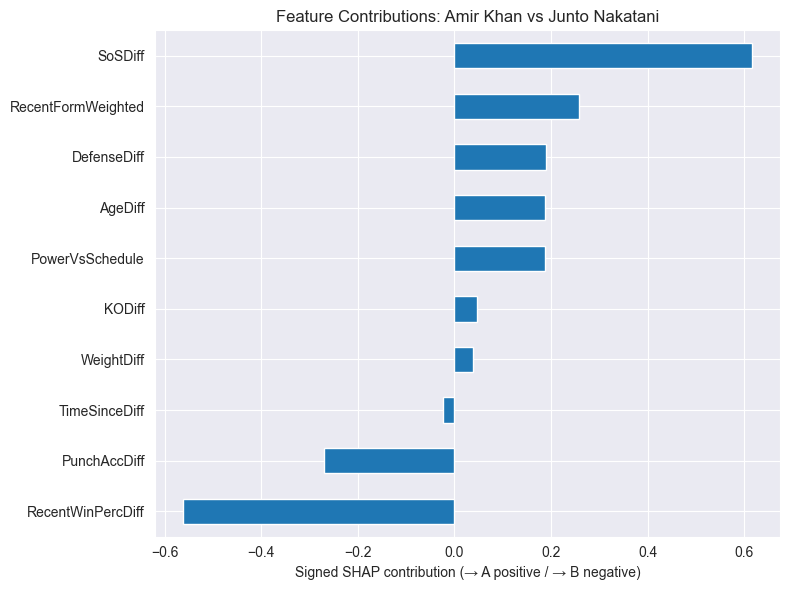

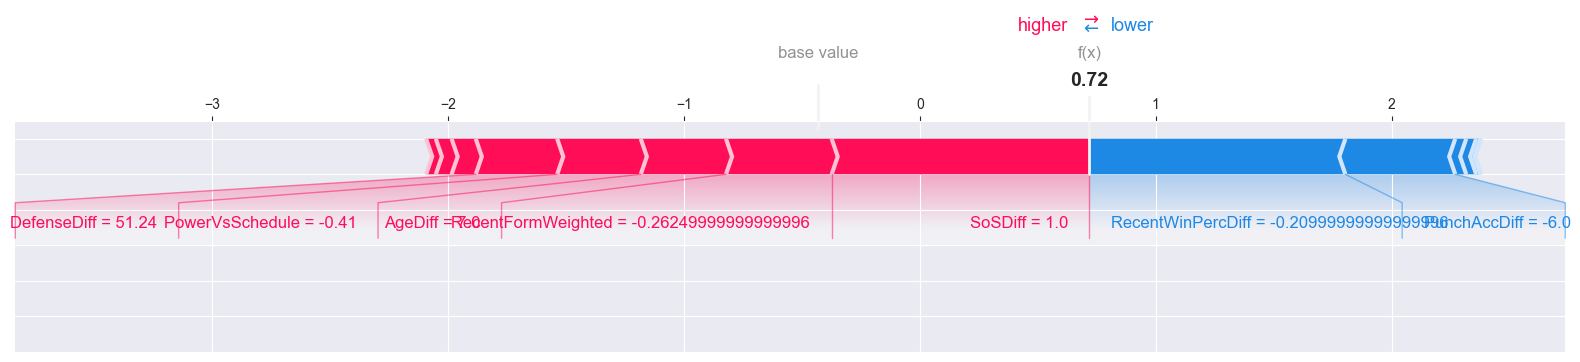


Saved: explanations\Amir_Khan_vs_Junto_Nakatani_explanation.csv
Saved: explanations\Amir_Khan_vs_Junto_Nakatani_explanation.json


In [44]:
# ==== UPDATED explain_fight(...) with optional SHAP force plot ====
def explain_fight(
        fighterA,
        fighterB,
        model=final_model_calibrated,
        imputer_obj=imputer,
        top_k=10,
        out_dir="explanations",
        show_force=False  # NEW FLAG
):
    """
    Explains the prediction using SHAP where possible.
    Positive values push toward Fighter A winning.
    Falls back to RF-importances × diffs if SHAP is unavailable.
    Optionally shows SHAP force plot for a single fight.
    """
    os.makedirs(out_dir, exist_ok=True)

    # Resolve fighters + build row
    A = _resolve_name(fighterA, all_fighters)
    B = _resolve_name(fighterB, all_fighters)
    statsA, statsB = fighters_stats[A], fighters_stats[B]
    X_pred = _build_feature_row(statsA, statsB)
    X_pred = pd.DataFrame(imputer_obj.transform(X_pred), columns=feature_cols)

    feature_values = X_pred.iloc[0]
    contrib_series = None
    method_label, xlabel = None, None

    shap_values_xgb, shap_values_rf = None, None  # for optional force plot

    # Try SHAP (on individual models, not ensemble)
    if HAS_SHAP:
        try:
            # XGBoost SHAP
            explainer_xgb = shap.Explainer(xgb_best, X_train_res)
            shap_values_xgb = explainer_xgb(X_pred)
            shap_mean_xgb = shap_values_xgb.values.mean(axis=0)  # (n_features,)

            # RF SHAP
            explainer_rf = shap.TreeExplainer(rf_best)
            shap_values_rf = explainer_rf.shap_values(X_pred)

            if isinstance(shap_values_rf, list):
                # Pick class 1 = Fighter A wins
                shap_mean_rf = shap_values_rf[1].mean(axis=0)  # (n_features,)
            else:
                # Single array, may be (n_samples, n_features) or (n_samples, n_features, 2)
                if shap_values_rf.ndim == 3:
                    # shape (n_samples, n_features, 2) → take class 1
                    shap_mean_rf = shap_values_rf[:, :, 1].mean(axis=0)
                else:
                    # shape (n_samples, n_features)
                    shap_mean_rf = shap_values_rf.mean(axis=0)

            # Now both are (n_features,) and safe to add
            shap_values_map = (shap_mean_xgb + shap_mean_rf) / 2
            contrib_series = pd.Series(shap_values_map, index=feature_cols)

            method_label = "SHAP (RF + XGB averaged)"
            xlabel = "Signed SHAP contribution (→ A positive / → B negative)"

        except Exception as e:
            logging.warning(f"SHAP failed, falling back to RF importances: {e}")

    if contrib_series is None:
        # Fallback: RF importances × diffs
        rf_importances = pd.Series(rf_best.feature_importances_, index=feature_cols).clip(lower=0)
        contrib_series = feature_values * rf_importances
        method_label = "RF importances × diffs (fallback)"
        xlabel = "Signed contribution (diff × importance)"

    # Prediction from ensemble
    proba_A = model.predict_proba(X_pred)[0, 1]

    # === NEW: adjust with technical features (now contrib_series is ready)
    proba_A_adj = adjust_with_tech_skills(proba_A, contrib_series)

    winner = A if proba_A_adj >= 0.5 else B
    confidence = float(proba_A_adj if proba_A_adj >= 0.5 else 1 - proba_A_adj)

    # Top-k by absolute magnitude
    top_feats = contrib_series.abs().sort_values(ascending=False).head(top_k).index
    top_contrib = contrib_series[top_feats].sort_values()

    # Text summary
    print(f"🥊 {A} vs {B}")
    print(f"Predicted winner: {winner} (Confidence: {confidence:.2%})")
    print(f"Explanation method: {method_label}")
    print("\nTop contributing factors (positive → pushes toward A; negative → toward B):")
    for feat in top_feats:
        print(f" - {feat}: value={feature_values[feat]:.4f}, contribution={contrib_series[feat]:.4f}")

    # Plot top-k contributions
    plt.figure(figsize=(8, 6))
    top_contrib.plot(kind="barh")
    plt.title(f"Feature Contributions: {A} vs {B}")
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

    # === NEW: Optional SHAP force plot ===
    if show_force and HAS_SHAP and shap_values_xgb is not None:
        try:
            shap.initjs()
            shap.force_plot(
                shap_values_xgb.base_values[0],
                shap_values_xgb.values[0],
                X_pred.iloc[0],
                matplotlib=True,
                show=True
            )
        except Exception as e:
            logging.warning(f"Could not render SHAP force plot: {e}")

    # Save CSV + JSON
    base = f"{A.replace(' ','_')}_vs_{B.replace(' ','_')}"
    csv_path = os.path.join(out_dir, f"{base}_explanation.csv")
    json_path = os.path.join(out_dir, f"{base}_explanation.json")

    rows = []
    for f in top_feats:
        rows.append({
            "feature": f,
            "feature_value": float(feature_values[f]),
            "contribution": float(contrib_series[f]),
            "note": "Positive → toward Fighter A; Negative → toward Fighter B"
        })
    pd.DataFrame(rows).to_csv(csv_path, index=False)

    rec = {
        "fighter_A": A, "fighter_B": B,
        "winner": winner, "confidence": confidence,
        "proba_A_raw": float(proba_A),
        "proba_A_adj": float(proba_A_adj),   # NEW
        "method": method_label,
        "top_contributions": rows
    }
    with open(json_path, "w") as f:
        json.dump(rec, f, indent=2)

    print(f"\nSaved: {csv_path}")
    print(f"Saved: {json_path}")


# Example usage
explain_fight("Amir Khan", "Junto Nakatani", show_force=True)

In [38]:
def historical_replay(df_subset, model=final_model_calibrated, imputer_obj=imputer):
    """
    Re-run predictions on historical rows in df_subset and compare to actual Result.
    df_subset must contain FighterA, FighterB, and engineered feature columns + Result.
    """
    needed = set(feature_cols + ["Result", "FighterA", "FighterB"])
    missing = needed - set(df_subset.columns)
    if missing:
        raise ValueError(f"df_subset is missing columns: {missing}")

    X_eval = df_subset[feature_cols].copy()
    y_true = df_subset["Result"].astype(int).values
    X_eval = pd.DataFrame(imputer_obj.transform(X_eval), columns=feature_cols)

    y_proba = model.predict_proba(X_eval)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    print("\n=== Historical Replay ===")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Accuracy:", (y_pred == y_true).mean())
    print("Balanced Accuracy:", balanced_accuracy_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_proba))
    print("Macro F1:", f1_score(y_true, y_pred, average="macro"))

    out = df_subset[["FighterA","FighterB","Result"]].copy()
    out["proba_A_win"] = y_proba
    out["pred_A_win"] = y_pred
    out["correct"] = (y_pred == y_true).astype(int)
    return out

# Convenience: replay on the exact test rows you held out
test_index = X_test.index
df_test_rows = df.loc[test_index].copy()  # these rows already have engineered features + Result
replay_report = historical_replay(df_test_rows)
replay_report.head()


=== Historical Replay ===
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        22
           1       0.86      0.95      0.90        39

    accuracy                           0.87        61
   macro avg       0.87      0.84      0.85        61
weighted avg       0.87      0.87      0.87        61

Confusion Matrix:
 [[16  6]
 [ 2 37]]
Accuracy: 0.8688524590163934
Balanced Accuracy: 0.837995337995338
ROC AUC: 0.8554778554778555
Macro F1: 0.851219512195122


,FighterA,FighterB,Result,proba_A_win,pred_A_win,correct
211,Brian Castano,Patrick Teixeira,1,0.851125,1,1
92,Max Schmeling,Joe Louis,0,0.281357,0,1
137,Mikkel Kessler,Carl Froch,0,0.028467,0,1
63,Johnny Tapia,Paulie Ayala,0,0.914372,1,0
124,Bob Foster,Joe Frazier,0,0.733724,1,0


In [39]:
# --- CLEANERS ---
def clean_stat(value: str) -> str:
    if not isinstance(value, str):
        return value
    value = re.sub(r"\[\d+\]", "", value)  # remove citations like [1]
    value = value.replace("½", ".5").replace("⁄", "/").replace("+", "")
    return value.strip()

def parse_height(height_str):
    height_str = clean_stat(height_str)
    m = re.search(r"\((\d+)\s*cm\)", height_str)
    return float(m.group(1)) if m else np.nan

def parse_reach(reach_str):
    reach_str = clean_stat(reach_str)
    m = re.search(r"\((\d+)\s*cm\)", reach_str)
    return float(m.group(1)) if m else np.nan

def parse_weight(weight_str):
    weight_str = clean_stat(weight_str)
    m = re.search(r"\(([\d.]+)\s*kg\)", weight_str)
    return float(m.group(1)) if m else np.nan

In [40]:
# --- WIKIPEDIA SEARCH ---
def wiki_search(name):
    url = "https://en.wikipedia.org/w/api.php"
    params = {"action": "query","list": "search","srsearch": name + " boxer","format": "json"}
    headers = {"User-Agent": "FightPredictorBot/1.0 (contact: you@example.com)"}
    try:
        resp = requests.get(url, params=params, headers=headers, timeout=10)
        data = resp.json()
        if "query" in data and data["query"]["search"]:
            return data["query"]["search"][0]["title"]
    except Exception as e:
        logging.warning(f"Wikipedia search failed for {name}: {e}")
    return None

def fetch_wiki_stats(name):
    page_title = wiki_search(name)
    if not page_title:
        return {}
    url = f"https://en.wikipedia.org/wiki/{page_title.replace(' ', '_')}"
    headers = {"User-Agent": "FightPredictorBot/1.0 (contact: you@example.com)"}
    try:
        resp = requests.get(url, headers=headers, timeout=10)
        if resp.status_code != 200:
            return {}
        soup = BeautifulSoup(resp.text, "html.parser")
        infobox = soup.find("table", {"class": "infobox"})
        stats = {}
        if infobox:
            for row in infobox.find_all("tr"):
                th, td = row.find("th"), row.find("td")
                if th and td:
                    key, val = th.text.strip(), td.text.strip().replace("\xa0", " ")
                    if key in ("Height", "Reach", "Weight"):
                        stats[key.lower()] = clean_stat(val)
        return stats
    except Exception as e:
        logging.warning(f"Wikipedia fetch failed for {name}: {e}")
        return {}

def get_fighter_data(name, base_dict):
    base = base_dict.get(name, {
        "Reach": np.nan, "Age": np.nan, "Height": np.nan, "Weight": np.nan,
        "KO%": np.nan, "Wins": np.nan, "RecentWin%": np.nan,
        "Defense%": np.nan, "PunchAcc": np.nan, "SoS": np.nan, "TimeSince": np.nan
    }).copy()

    wiki_stats = fetch_wiki_stats(name)
    if wiki_stats:
        if "height" in wiki_stats and pd.isna(base["Height"]):
            base["Height"] = parse_height(wiki_stats["height"])
        if "reach" in wiki_stats and pd.isna(base["Reach"]):
            base["Reach"] = parse_reach(wiki_stats["reach"])
        if "weight" in wiki_stats and pd.isna(base["Weight"]):
            base["Weight"] = parse_weight(wiki_stats["weight"])
    return base

def validate_dataset_with_wiki(csv_path, sample_size=50, tolerance=2.0):
    df0 = pd.read_csv(csv_path)
    fighters = sorted(set(df0["FighterA"]).union(df0["FighterB"]))
    if sample_size:
        fighters = np.random.choice(fighters, size=min(sample_size, len(fighters)), replace=False)

    report = []
    for fighter in fighters:
        wiki = fetch_wiki_stats(fighter)
        row = {"Fighter": fighter}
        if not wiki:
            row["Note"] = "⚠️ Not found on Wikipedia"
            report.append(row); continue
        if "height" in wiki: row["Height_wiki"] = parse_height(wiki["height"])
        if "reach" in wiki:  row["Reach_wiki"]  = parse_reach(wiki["reach"])
        if "weight" in wiki: row["Weight_wiki"] = parse_weight(wiki["weight"])

        if fighter in df0["FighterA"].values:
            s = df0.loc[df0["FighterA"] == fighter].iloc[0]
            row["Height_csv"], row["Reach_csv"], row["Weight_csv"] = s["HeightA"], s["ReachA"], s["WeightA"]
        elif fighter in df0["FighterB"].values:
            s = df0.loc[df0["FighterB"] == fighter].iloc[0]
            row["Height_csv"], row["Reach_csv"], row["Weight_csv"] = s["HeightB"], s["ReachB"], s["WeightB"]

        note = []
        for stat in ("Height", "Reach", "Weight"):
            c, w = row.get(f"{stat}_csv"), row.get(f"{stat}_wiki")
            if pd.notna(c) and pd.notna(w) and abs(c - w) > tolerance:
                note.append(f"{stat} differs (CSV={c}, Wiki={w})")
        row["Note"] = " | ".join(note)
        report.append(row)

    return pd.DataFrame(report)

# Example audit (optional)
# discrepancies = validate_dataset_with_wiki("boxing_data.csv", sample_size=50, tolerance=2.0)
# discrepancies.to_csv("wiki_audit_report.csv", index=False)
# discrepancies.head()

In [41]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ensemble, X, y, cv=5, scoring="accuracy")
print(scores.mean(), scores.std())

0.7466120218579235 0.025576806134343696


               feature  importance
9              SoSDiff    0.864304
11     PowerVsSchedule    0.791720
6    RecentWinPercDiff    0.570765
8         PunchAccDiff    0.286564
1              AgeDiff    0.281424
7          DefenseDiff    0.173137
12      WinsVsSchedule    0.163124
13  RecentFormWeighted    0.145315
0            ReachDiff    0.127821
2           HeightDiff    0.100457
4               KODiff    0.098863
10       TimeSinceDiff    0.081053
3           WeightDiff    0.062506
5              WinDiff    0.059237


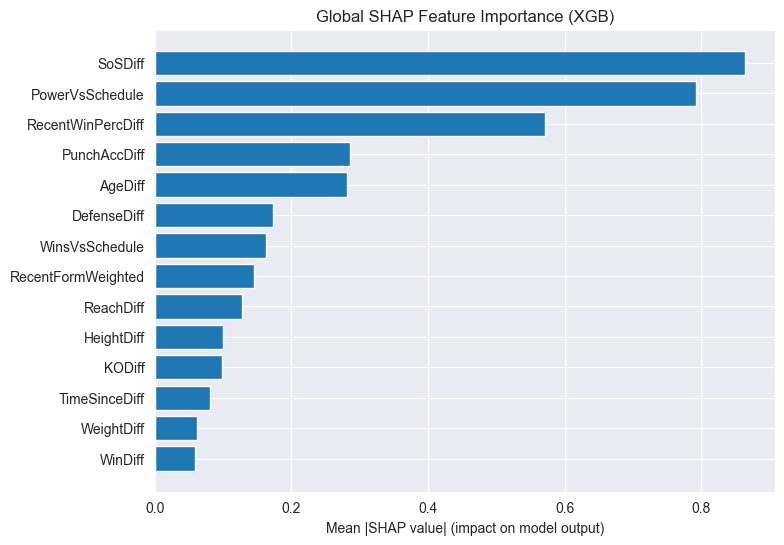

In [42]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Use the same data you trained with (after imputation etc.)
X_all = pd.DataFrame(imputer.transform(X_train_res), columns=feature_cols)

# Use explainer for one of the models (e.g., XGB) 
# or ensemble approach if you want consistency with your function
explainer = shap.Explainer(xgb_best, X_train_res)
shap_values = explainer(X_all)

# Compute mean absolute SHAP values per feature
mean_abs_shap = pd.DataFrame({
    "feature": feature_cols,
    "importance": np.abs(shap_values.values).mean(axis=0)
}).sort_values("importance", ascending=False)

print(mean_abs_shap)

# Plot
plt.figure(figsize=(8,6))
plt.barh(mean_abs_shap["feature"], mean_abs_shap["importance"])
plt.gca().invert_yaxis()
plt.title("Global SHAP Feature Importance (XGB)")
plt.xlabel("Mean |SHAP value| (impact on model output)")
plt.show()